In [488]:
library(tibble)

library(ggplot2)
library(cowplot)
theme_set(theme_bw())

# library(scran)
# library(sva)
# library(Harman)


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [489]:
# source files
src_files <- list.files('../../R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../../R/calc.R
Sourced file: ../../R/misc.R
Sourced file: ../../R/normalise.R
Sourced file: ../../R/plot.R
Sourced file: ../../R/predict.R
Sourced file: ../../R/subset.R
Sourced file: ../../R/utils.R


## Import data

In [337]:
file_maqc <- "../../../diff_expr/data/MAQC-I/processed/mas5_original-ref.tsv"
raw_maqc <- read.table(file_maqc, sep = "\t", header = T, row.names = 1)

# MAQC metadata
# Class A - Universal Human Reference RNA (UHRR)
# Class B - Human Brain Reference RNA (HBRR)
batch_info <- as.factor(rep(1:6, each = 10))
class_info <- rep(rep(LETTERS[1:2], each = 5), 6)
metadata <- data.frame(batch_info, class_info, row.names = colnames(raw_maqc))

# SCALE->REMOVE->FILTER->LOG
log_maqc <- raw_maqc %>%
  normaliseMeanScaling() %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

AFX_1_A1 AFX_1_A2 AFX_1_A3 AFX_1_A4 AFX_1_A5 AFX_1_B1 
6.167267 4.921776 6.064782 5.998307 5.594024 6.396092 
[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


In [115]:
log_nozero <- log_maqc[rowSums(log_maqc == 0) == 0, ]

## Affy probesets

In [269]:
is_affy <- startsWith(rownames(raw_maqc), 'AFFX')
log_affy <- log2_transform(raw_maqc[is_affy, ])

# pdf('~/Dropbox/tmp/sum-lg_affy.pdf', width = 4, height = 4)
# hist(rowSums(log_affy), breaks = 20)
# dev.off()

# selecting affy probesets with high expression (positive controls)
idx_affy <- rownames(log_affy)[rowSums(log_affy) > 200]
raw_affy <- raw_maqc[idx_affy, ]
raw_notaffy <- raw_maqc[!is_affy, ]

In [270]:
print(identical(rownames(metadata), colnames(raw_affy)))
raw_stats <- data.frame(
  metadata,
  sum_affy = colSums(raw_affy),
  sum_notaffy = colSums(raw_notaffy),
  pct_zero_affy = colSums(raw_affy == 0) / nrow(raw_affy), 
  pct_zero_notaffy = colSums(raw_notaffy == 0) / nrow(raw_notaffy),
  avg_nonzero_affy = colSums(raw_affy) / colSums(raw_affy != 0),
  avg_nonzero_notaffy = colSums(raw_notaffy) / colSums(raw_notaffy != 0),
  log_avg_nonzero_affy = log(colSums(raw_affy) / colSums(raw_affy != 0)),
  log_avg_nonzero_notaffy = log(colSums(raw_notaffy) / colSums(raw_notaffy != 0)),
  avg_affy = log2(colSums(raw_affy) / nrow(raw_affy)),
  avg_notaffy = log2(colSums(raw_notaffy) / nrow(raw_notaffy))
)

[1] TRUE


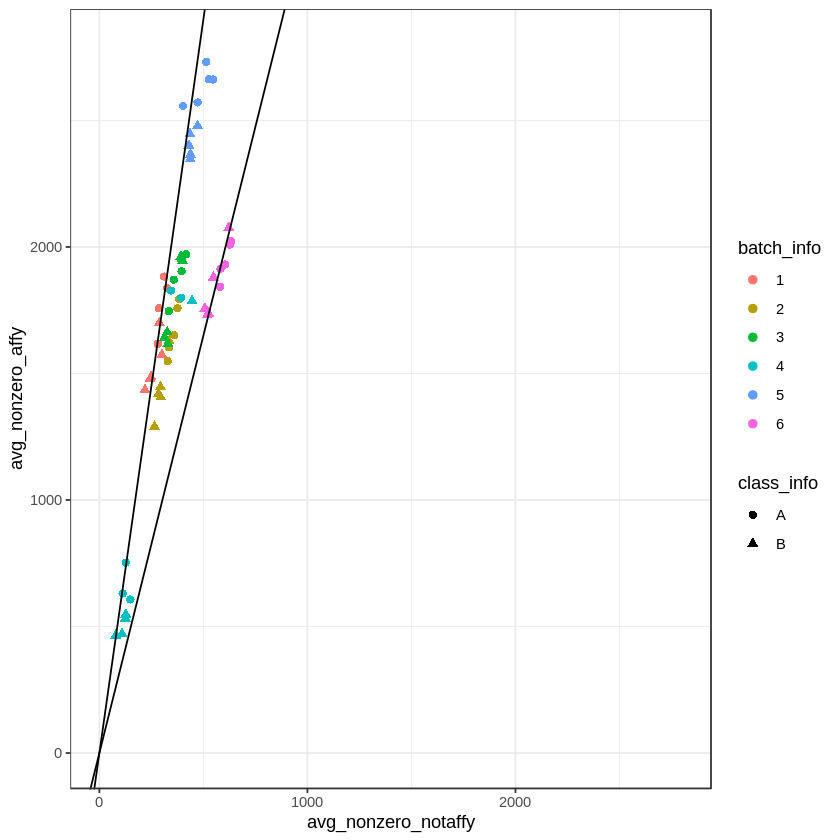

In [301]:
# raw_stats['ratio_avg_nonzero'] <-
#   raw_stats$avg_nonzero_notaffy / raw_stats$avg_nonzero_affy

# ax <- ggplot(raw_stats) +
#   geom_point(
#     aes(
#       x = batch_info, y = avg_nonzero_notaffy,
#       col = batch_info, shape = class_info
#     ),
#     cex = 3,
#     position = position_jitterdodge(jitter.width = 3)
#   )

upper <- 2800
ax <- ggplot(raw_stats) +
  geom_point(
    aes(
      x = avg_nonzero_notaffy, y = avg_nonzero_affy,
      col = batch_info, shape = class_info
    ),
    cex = 2
  ) +
  xlim(0, upper) + ylim(0, upper) +
  geom_abline(intercept = 0, slope = 5.8) +
  geom_abline(intercept = 0, slope = 3.3)

ax

# ggsave(
#   '~/Dropbox/tmp/maqc_vs_raw-avg_nonzero.pdf',
#    ax, width = 5, height = 4
# )

## Batch correction factor
- Calculation of batch correction factor and multiplication of factor to affy features

In [338]:
is_affy <- startsWith(rownames(raw_maqc), 'AFFX')
log_affy <- log2_transform(raw_maqc[is_affy, ])

# pdf('~/Dropbox/tmp/sum-lg_affy.pdf', width = 4, height = 4)
# hist(rowSums(log_affy), breaks = 20)
# dev.off()

# selecting affy probesets with high expression (positive controls)
idx_affy <- rownames(log_affy)[rowSums(log_affy) > 200]
raw_affy <- raw_maqc[idx_affy, ]
raw_notaffy <- raw_maqc[!is_affy, ]

In [475]:
scaled_affy <- scale_batch_affy(raw_maqc, metadata, idx_affy)

Scaled batch 1 with original slope of 5.86 to 4.88
Scaled batch 2 with original slope of 4.77 to 4.88
Scaled batch 3 with original slope of 4.98 to 4.88
Scaled batch 4 with original slope of 4.56 to 4.88
Scaled batch 5 with original slope of 5.37 to 4.88
Scaled batch 6 with original slope of 3.28 to 4.88


In [476]:
print(identical(rownames(metadata), colnames(scaled_affy)))
scaled_affy_stats <- data.frame(
  metadata,
  sum_affy = colSums(scaled_affy),
  sum_notaffy = colSums(raw_notaffy),
  pct_zero_affy = colSums(scaled_affy == 0) / nrow(scaled_affy), 
  pct_zero_notaffy = colSums(raw_notaffy == 0) / nrow(raw_notaffy),
  avg_nonzero_affy = colSums(scaled_affy) / colSums(scaled_affy != 0),
  avg_nonzero_notaffy = colSums(raw_notaffy) / colSums(raw_notaffy != 0),
  log_avg_nonzero_affy = log(colSums(scaled_affy) / colSums(scaled_affy != 0)),
  log_avg_nonzero_notaffy = log(colSums(raw_notaffy) / colSums(raw_notaffy != 0)),
  avg_affy = log2(colSums(scaled_affy) / nrow(scaled_affy)),
  avg_notaffy = log2(colSums(raw_notaffy) / nrow(raw_notaffy))
)

[1] TRUE


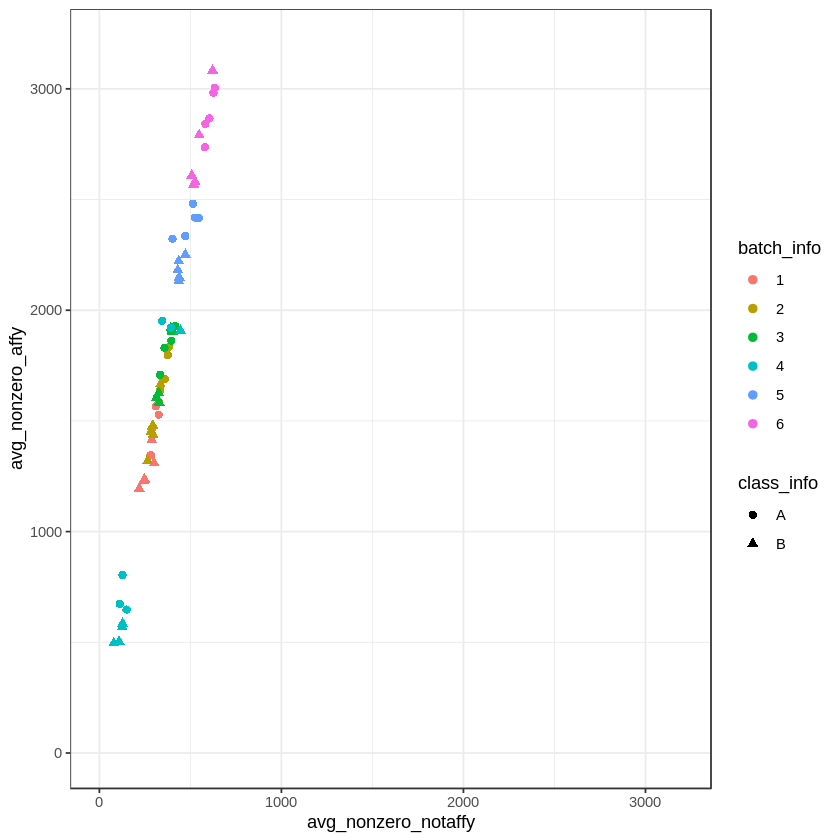

In [477]:
# ax <- ggplot(scaled_affy_stats) +
#   geom_point(
#     aes(
#       x = batch_info, y = avg_nonzero_affy,
#       col = batch_info, shape = class_info
#     ),
#     cex = 3,
#     position = position_jitterdodge(jitter.width = 3)
#   )

upper <- 3200
ax <- ggplot(scaled_affy_stats) +
  geom_point(
    aes(
      x = avg_nonzero_notaffy, y = avg_nonzero_affy,
      col = batch_info, shape = class_info
    ),
    cex = 2
  ) +
  xlim(0, upper) + ylim(0, upper)

ax

ggsave(
  '~/Dropbox/tmp/maqc_vs-batch_scaled_affy.pdf',
   ax, width = 5, height = 4
)

## Affy mean scaling

In [144]:
# divide by no. of non-zero values
avg_nonzero_affy <- colSums(raw_affy) / colSums(raw_affy != 0)
scale_factor <- 500 / avg_nonzero_affy
affyms_maqc <- sweep(raw_maqc, 2, scale_factor, `*`)

log_affyms_maqc <- affyms_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

log_affyms_nozero <- log_affyms_maqc[rowSums(log_affyms_maqc == 0) == 0, ]

## Batch scaled affy

In [478]:
# divide by no. of non-zero values
avg_nonzero_affy <- colSums(scaled_affy) / colSums(scaled_affy != 0)
scale_factor <- 500 / avg_nonzero_affy
affyms_maqc <- sweep(raw_maqc, 2, scale_factor, `*`)

log_affyms_maqc <- affyms_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

log_affyms_nozero <- log_affyms_maqc[rowSums(log_affyms_maqc == 0) == 0, ]

[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


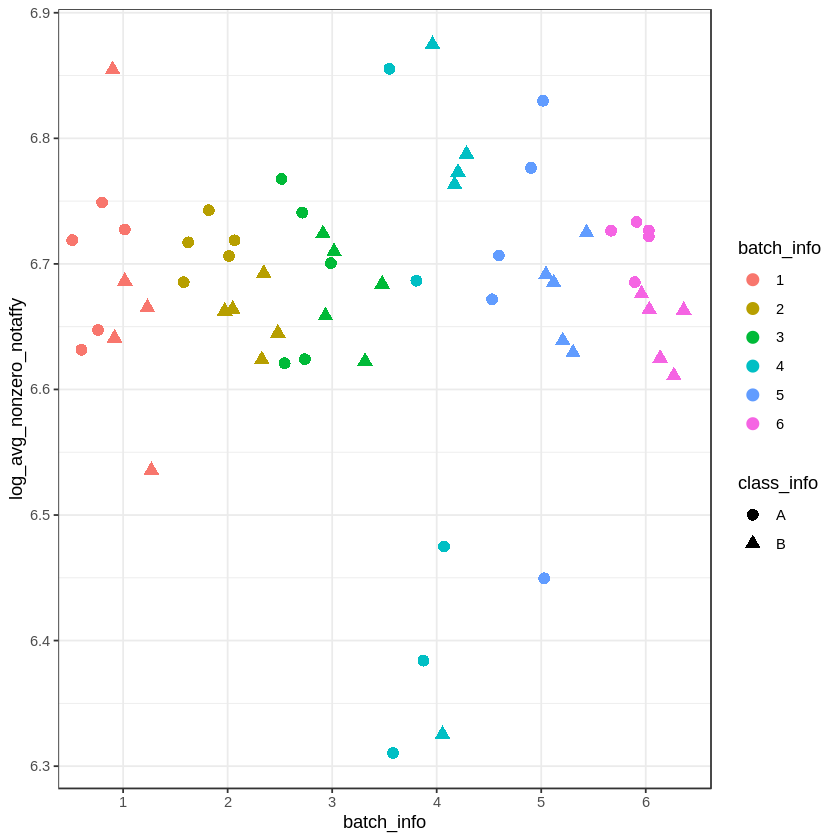

In [486]:
# print(identical(rownames(metadata), colnames(affyms_maqc)))
affyms_stats <- data.frame(
  metadata,
  log_avg_nonzero_notaffy = log2(colSums(affyms_maqc) / colSums(affyms_maqc != 0)),
  avg_nonzero_notaffy = colSums(log_affyms_maqc) / colSums(log_affyms_maqc != 0)
)
ax <- ggplot(affyms_stats) +
  geom_point(
    aes(
      x = batch_info, y = log_avg_nonzero_notaffy,
      col = batch_info, shape = class_info
    ),
    cex = 3,
    position = position_jitterdodge(jitter.width = 3)
  )
ax

# ggsave(
#   '~/Dropbox/tmp/maqc_avg_nonzero_notaffy-batch_affyms.pdf',
#    ax, width = 6, height = 4
# )

[1] TRUE


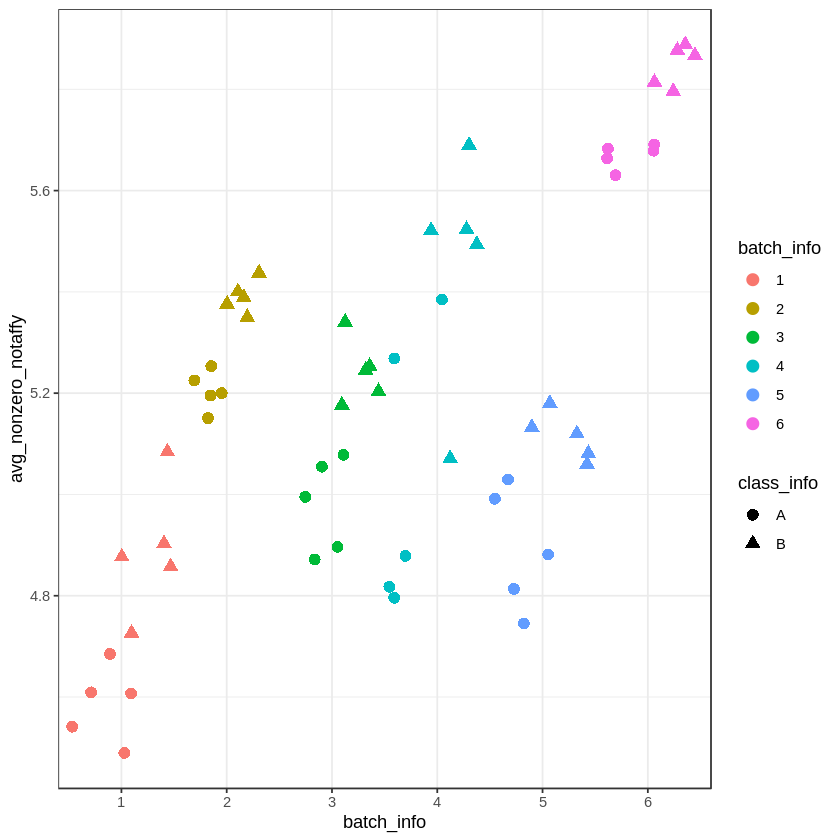

In [148]:
# print(identical(rownames(metadata), colnames(affyms_maqc)))
# affyms_stats <- data.frame(
#   metadata,
#   avg_nonzero_notaffy = colSums(log_affyms_maqc) / colSums(log_affyms_maqc != 0)
# )

# ax <- ggplot(affyms_stats) +
#   geom_point(
#     aes(
#       x = batch_info, y = avg_nonzero_notaffy,
#       col = batch_info, shape = class_info
#     ),
#     cex = 3,
#     position = position_jitterdodge(jitter.width = 3)
#   )
# ax

# ggsave(
#   '~/Dropbox/tmp/maqc_avg_nozero_notaffy-affyms.pdf',
#    ax, width = 6, height = 4
# )

## PCA

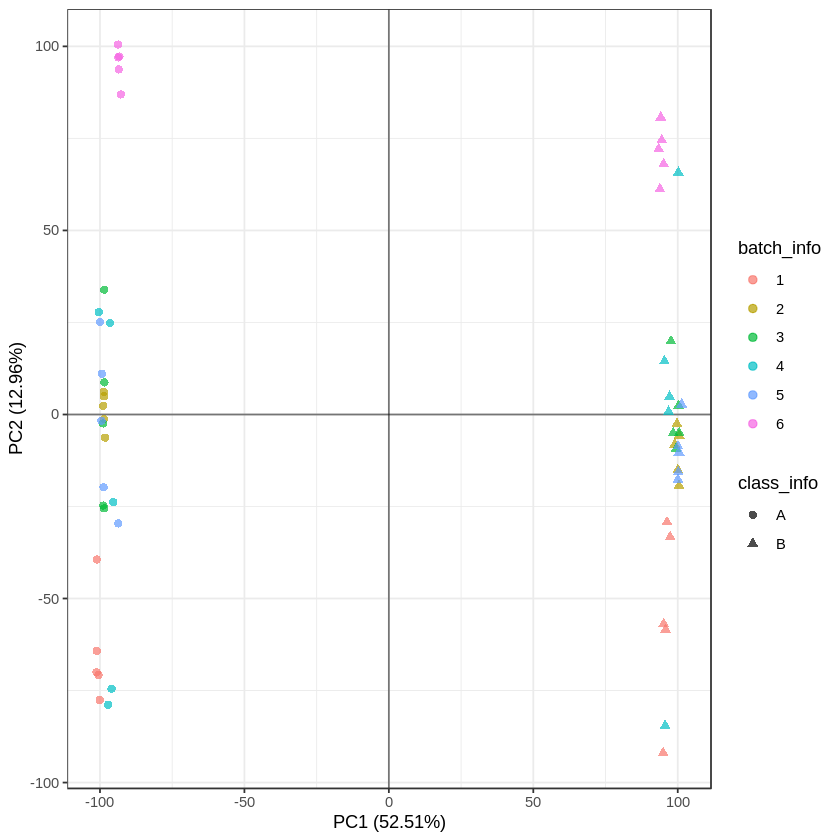

In [482]:
ax1 <- ggplot_pca(
  log_maqc, metadata,
  col = 'batch_info', pch = 'class_info'
)
ax2 <- ggplot_pca(
  log_affyms_maqc, metadata,
  col = 'batch_info', pch = 'class_info'
)
ax2
ggsave('~/Dropbox/tmp/maqc_pca-log_batch_affyms.pdf', ax2, width = 6, height = 4)

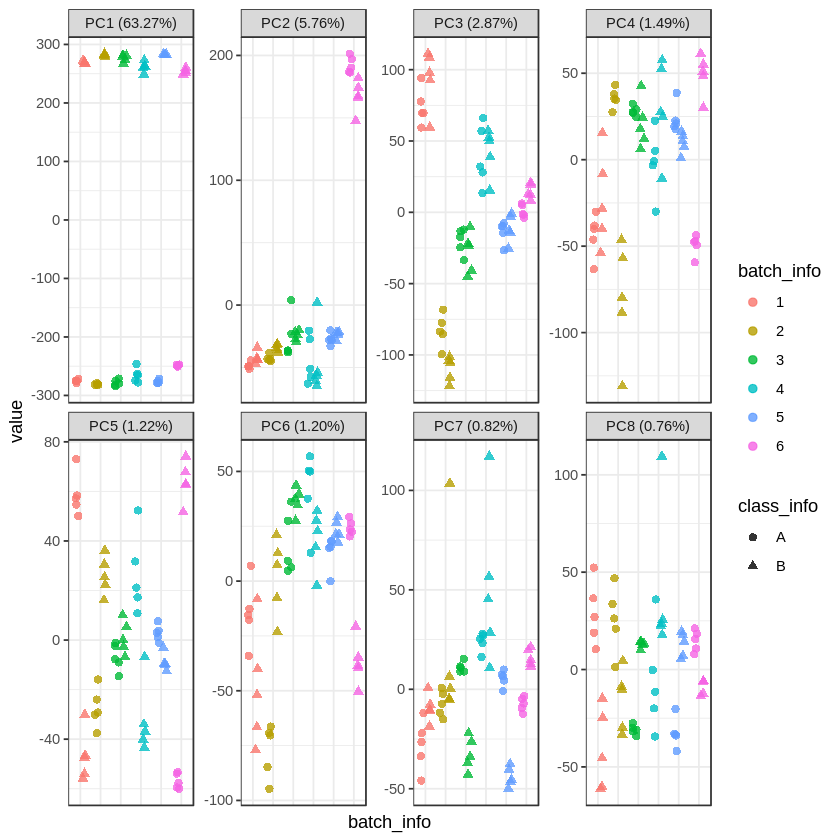

In [493]:
ax1 <- ggplot_top_pc(
  log_maqc, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax2 <- ggplot_top_pc(
  log_affyms_maqc, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax1
ggsave('~/Dropbox/tmp/maqc_top_pc-log_batchaffyms.pdf', ax2, width = 8, height = 4)

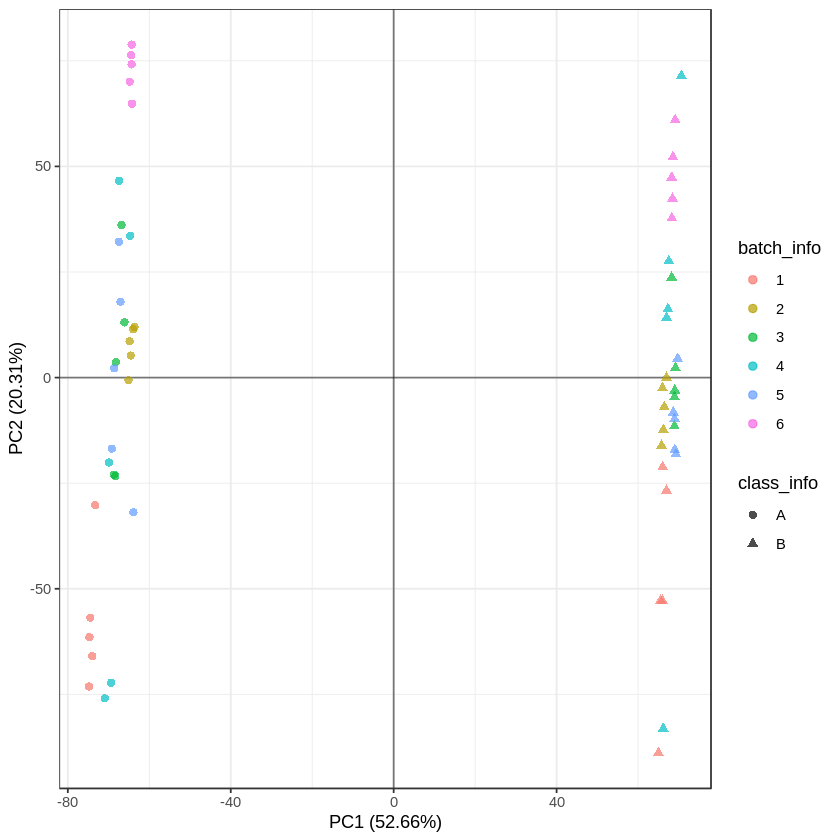

In [483]:
ax1 <- ggplot_pca(
  log_nozero, metadata,
  col = 'batch_info', pch = 'class_info'
)
ax2 <- ggplot_pca(
  log_affyms_nozero, metadata,
  col = 'batch_info', pch = 'class_info'
)
ax2
ggsave('~/Dropbox/tmp/maqc_pca-log_batch_affyms_nonzero.pdf', ax2, width = 6, height = 4)

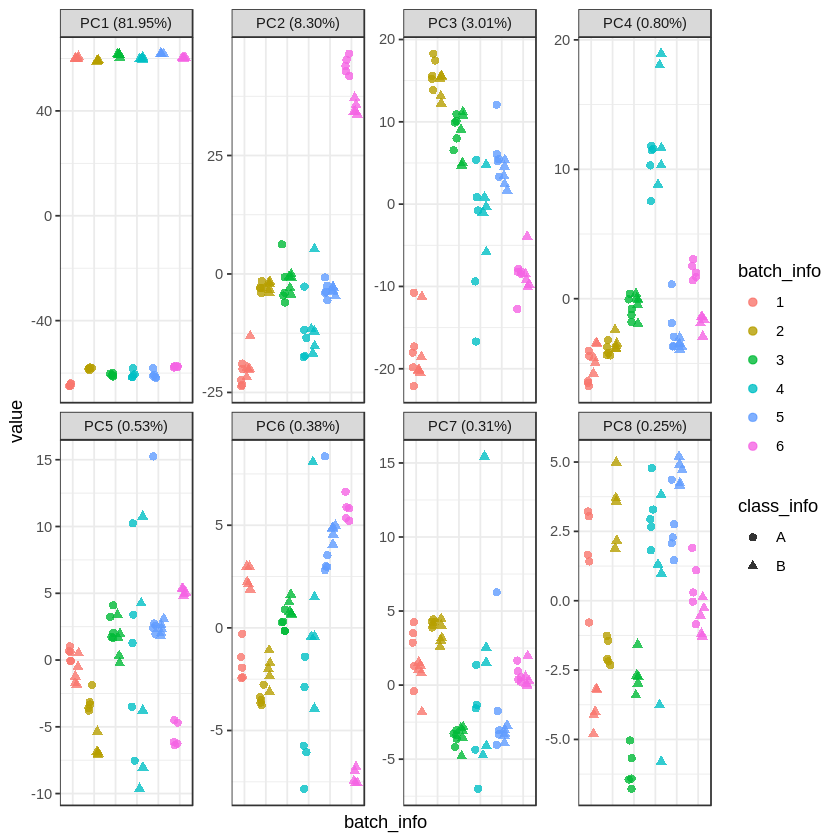

In [495]:
ax1 <- ggplot_top_pc(
  log_nozero, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax2 <- ggplot_top_pc(
  log_affyms_nozero, metadata,
  x_axis = "batch_info",  color = "batch_info", shape = "class_info"
)
ax1
ggsave('~/Dropbox/tmp/maqc_top_pc-log_batchaffyms_nozero.pdf', ax2, width = 8, height = 4)

### Investigation

In [201]:
log_raw <- log2_transform(raw_maqc)

In [241]:
a1_2 <- log_raw[['AFX_2_A1']]
a2_2 <- log_raw[['AFX_2_A2']]
a3_2 <- log_raw[['AFX_2_A3']]
b1_2 <- log_raw[['AFX_2_B1']]
b2_2 <- log_raw[['AFX_2_B2']]

a1_3 <- log_raw[['AFX_3_A1']]
a2_3 <- log_raw[['AFX_3_A2']]
a3_3 <- log_raw[['AFX_3_A3']]
b1_3 <- log_raw[['AFX_3_B1']]
b2_3 <- log_raw[['AFX_3_B2']]

a1_5 <- log_raw[['AFX_5_A1']]
a2_5 <- log_raw[['AFX_5_A2']]
a3_5 <- log_raw[['AFX_5_A3']]
b1_5 <- log_raw[['AFX_5_B1']]
b2_5 <- log_raw[['AFX_5_B2']]

a1_6 <- log_raw[['AFX_6_A1']]
a2_6 <- log_raw[['AFX_6_A2']]
b1_6 <- log_raw[['AFX_6_B1']]
b2_6 <- log_raw[['AFX_6_B2']]

In [235]:
x <- log_maqc[, 1]
max(x[x != 0])

[1] 16.13905

In [232]:
max(a1_5[a1_5 != 0])

[1] 13.70946

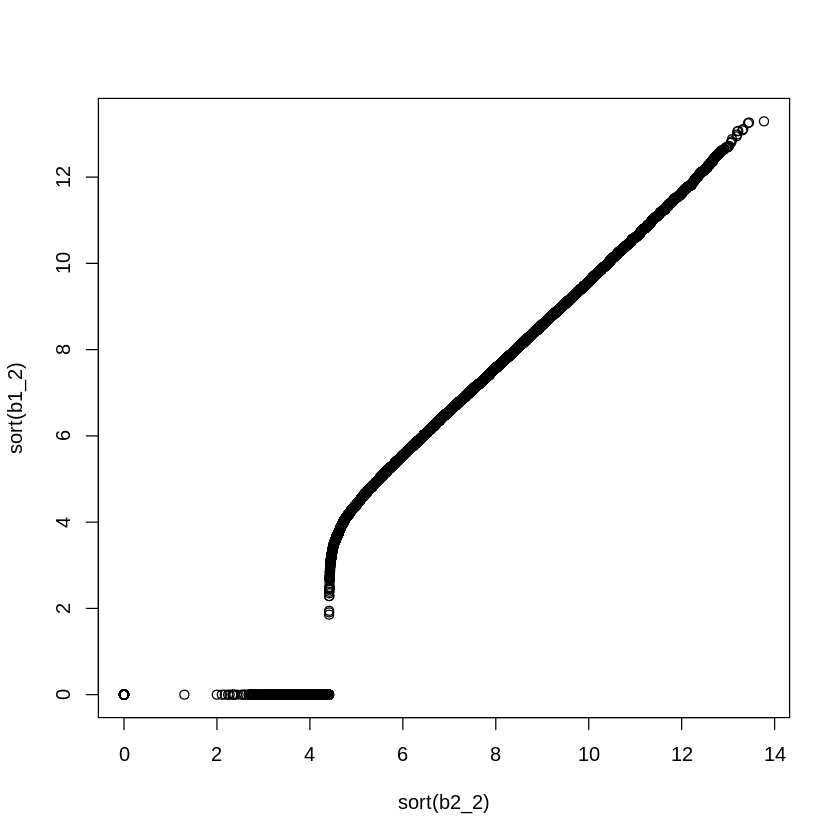

In [244]:
plot(sort(b2_2), sort(b1_2))

In [ ]:
# Investigate additive batch effects --------------------------------------
par(mfrow=c(1,2))
plot(log_maqc[,1], log_maqc[,11])
plot(log_maqc[,1], log_maqc[,2])

hist(log_maqc[,11] - log_maqc[,1], breaks = 50)
error_1 <- filtered_maqc[,11] - filtered_maqc[,1]

sub_error_1 <- error_1[abs(error_1) < 5000]
hist(sub_error_1, breaks = 50)
hist(rnorm(5000, 0, 2000), breaks = 50)

rlaplace <- function(n, mu, b) {
  X <- runif(n, -0.5, 0.5)
  mu - b*sign(X)*log(1-2*abs(X))  
}
hist(rlaplace(1000,0,1000), breaks = 20)

k <- 0.2
beta <- 0.001
hist(y, breaks = 50)
hist(sub_error_1, breaks = 50)

error_2 <- c(rgamma(1000, k, beta), -1 * rgamma(1000, k, beta))

# COMPARISON (EQUAL) ---------------------------------------------------------------
# No normalisation
class_letter <- ifelse(class_info == 1, "A", "B")
plot_before <- plot_batch(log_maqc, batch_info, class_letter)

foo_data <- data.frame(A = 1:10, B = 1:10)
batch_factor <- as.factor(1:10)
shape_factor <- rep(c("D0","D8","N"), c(3,3,4))

plot_foo <- ggplot(foo_data, aes(x = A, y = B, col = batch_factor, shape = shape_factor)) +
  geom_point(size = 3, show.legend = T) +
  scale_colour_manual(values = batch_palette) +
  scale_shape_manual(values=21:23) +
  labs(shape="Class", colour="Batch")

plot_foo
ggsave("dump/all_legend.pdf", plot_foo,
       width = 8, height = 8)

# ggsave("dump/plot_before.pdf", plot_before,
#        width = 6, height = 6)
# 
# selected_probesets <- filter_probesets(raw_maqc, 0.98)
# filtered_maqc <- raw_maqc[selected_probesets,]
# nrow(filtered_maqc)
# filtered_plot <- plot_batch(filtered_maqc, batch_info, shape_info)
# filtered_plot
# 
# # Mean-scaling
# scaled_maqc <- norm_mean_scaling(raw_maqc)
# plot_scaled <- plot_batch(scaled_maqc, batch_info, shape_info)
# plot_scaled
# ggsave("dump/plot_scaled.pdf", plot_scaled,
#        width = 6, height = 6)
# 
# # CDF
# rank_maqc <- norm.cdf(raw_maqc)
# plot_batch(rank_maqc, batch_info, shape_info)
# 
# # GFS
# gfs_maqc <- norm_gfs(raw_maqc)
# plot_gfs <- plot_batch(gfs_maqc, batch_info, shape_info)
# ggsave("dump/plot_gfs.pdf", plot_gfs,
#        width = 6, height = 6)

# MNN
# Split dataframe according to batch info
list_df <- split.default(filtered_maqc, batch_info)
# Convert df to arr
list_arr <- lapply(list_df, data.matrix)
list_args <- c(list_arr, k = 5, cos.norm.out = F)
mnn_maqc_obj <- do.call(mnnCorrect, list_args)
mnn_maqc_arr <- do.call(cbind, mnn_maqc_obj$corrected)
# Column names for matrix arranged in above order
colnames(mnn_maqc_arr) <- colnames(log_maqc)
plot_mnn <- plot_batch(data.frame(mnn_maqc_arr), batch_info, class_info)
plot_mnn

ggsave("dump/plot_mnn_log_scaled_k5.pdf", plot_mnn_log_scaled,
       width = 6, height = 6)

# Investigate MNNs ability to correct for multiplicative error

# Quantile normalisation
col_indx <- substring(colnames(log_maqc), 7, 7) == "A"
qnorm_a <- norm.quantile(log_maqc[,col_indx])
qnorm_b <- norm.quantile(log_maqc[,!col_indx])
qnorm_maqc <- cbind(qnorm_a, qnorm_b)
colnames(qnorm_maqc)
plot_qnorm <- plot_batch(qnorm_maqc, batch_info, class_info)
plot_qnorm
ggsave("dump/plot_class_qnorm.pdf", plot_qnorm,
       width = 6, height = 6)

# Harman
harman_obj <- harman(scaled_maqc, class_info, batch_info)
harman_maqc <- data.frame(reconstructData(harman_obj))

plot_harman <- plot_batch(harman_maqc, batch_info, class_info)
plot_harman
ggsave("dump/plot_harman.pdf", plot_harman,
       width = 6, height = 6)

# Scanorama
# Write log_maqc for numpy array
write.table(log_maqc, "data/scanorama/log_maqc.tsv",
            quote = F, sep = "\t", row.names = F, col.names = F)
write(rownames(log_maqc), file = "data/scanorama/probeset_names.txt")

scanorama_maqc <- read.table("data/scanorama/scanorama_data_k10.tsv",
                             sep = "\t", row.names = 1)
colnames(scanorama_maqc) <- colnames(log_maqc)
plot_scanorama <- plot_batch(scanorama_maqc, batch_info, class_info)
plot_scanorama
ggsave("dump/plot_scanorama_k10.pdf", plot_scanorama,
       width = 6, height = 6)

# ComBat ------------------------------------------------------------------
# Creation of pData dataframe (metadata)
class <- as.factor(class_info)
batch <- as.factor(batch_info)
maqc_metadata <- data.frame(class, batch)
# Rownames of metadata are same as colnames of data df
rownames(maqc_metadata) <- colnames(raw_maqc)
head(maqc_metadata)
# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
# Put batch variables directly in combat function
# model_combat <- model.matrix(~1, data = maqc_metadata)
# Include biological variable of interest as covariate
model_combat <- model.matrix(~class, data = maqc_metadata)

combat_maqc <- ComBat(data.matrix(filtered_maqc),
                      batch = maqc_metadata$batch,
                      mod = model_combat)
combat_maqc_df <- data.frame(combat_maqc)
# Replace negative values with 0
combat_maqc_df[combat_maqc_df < 0] <- 0

plot_combat <- plot_batch(combat_maqc_df, batch_info, class_info)
plot_combat

ggsave("dump/plot_FSL_combatCovariate.pdf", plot_combat,
       width = 6, height = 6)

# Log-transform data after mean-scaling
log_maqc <- log2_transform(filtered_maqc)
combat_log_maqc <- ComBat(data.matrix(log_maqc),
                          batch = maqc_metadata$batch,
                          mod = model_combat)
combat_log_maqc_df <- data.frame(combat_log_maqc)
# Replace negative values with 0
combat_log_maqc_df[combat_log_maqc_df < 0] <- 0

plot_combat_log_scaled <- plot_batch(combat_log_maqc_df, batch_info, shape_info)
ggsave("dump/plot_combat_log_scaled.pdf", plot_combat_log_scaled,
       width = 6, height = 6)

# CBC ---------------------------------------------------------------------
class_info <- ifelse(class_info == 1, "A", "B")
cbc_maqc <- norm.CBC(log_maqc, batch_info, class_info, 1:6, "dump/correction_log_maqc.tsv")

plot_cbc <- plot_batch(cbc_maqc, batch_info, class_info)
plot_cbc

ggsave("dump/plot_cbc.pdf", plot_cbc,
       width = 6, height = 6)

# Apply log first before scaling or normalisation
log_maqc <- log2_transform(raw_maqc)
scaled_log_maqc <- norm.mean_scaling(log_maqc)
cbc_scaled_log_maqc <- norm.CBC(scaled_log_maqc, batch_info, class_info, 1:6)
plot_log_raw <- plot_batch(log_maqc, batch_info, class_info)
plot_scaled_log <- plot_batch(scaled_log_maqc, batch_info, class_info)
plot_scaled_log
plot_cbc_scaled_log <- plot_batch(cbc_scaled_log_maqc, batch_info, class_info)

# Log-transform after scaling but before batch correction
log_scaled_maqc <- log2_transform(scaled_maqc)
cbc_log_scaled_maqc <- norm.CBC(log_scaled_maqc, batch_info, class_info, 1:6)
plot_cbc_log_scaled <- plot_batch(cbc_log_scaled_maqc, batch_info, class_info)
plot_log_cbc_log_scaled <- plot_batch(log2_transform(cbc_log_scaled_maqc), batch_info, class_info)

ggsave("dump/plot_cbc_log_scaled.pdf", plot_cbc_log_scaled,
       width = 6, height = 6)
ggsave("dump/plot_log_cbc_log_scaled.pdf", plot_log_cbc_log_scaled,
       width = 6, height = 6)

# PROPORTION DATASET --------------------------------------------------------
# Selects samples such that each batch has a diff proportion of classes
# Proportions rep(rep(LETTERS[1:2], 6), c(5,5,4,5,5,4,3,5,5,3,3,4))
selection_index <- c(1:10,11:14,16:20,21:25,26:29,31:33,36:40,41:45,46:48,51:53,56:59)
odd_maqc <- log_maqc[,selection_index]
odd_batch_info <- rep(1:6, c(10,9,9,8,8,7))
odd_class_info <- substring(colnames(odd_maqc), 7, 7)
odd_class_numeric <- ifelse(odd_class_info == "A", 1, 2)
odd_class_numeric
# TODO: SHOULD FILTER AGAIN!

ketchum <- eval.batch_effects(odd_maqc, odd_batch_info, odd_class_numeric)

pca_plot <- plot_batch(odd_maqc, odd_batch_info, odd_class_info)
pca_plot
ggsave("dump/pca_odd_maqc-uncorrected.pdf", pca_plot,
       width = 8, height = 4)

# Quantile
quantile_maqc <- norm.quantile(odd_maqc)
ketchum <- eval.batch_effects(quantile_maqc, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, quantile_maqc)

# ComBat
# Creation of pData dataframe (metadata)
class <- as.factor(odd_class_info)
batch <- as.factor(odd_batch_info)
odd_maqc_metadata <- data.frame(class, batch)
# Rownames of metadata are same as colnames of data df
rownames(odd_maqc_metadata) <- colnames(odd_maqc)
head(odd_maqc_metadata, 20)

# ComBat assumes that data has been normalised and probesets have been filtered
# Error if probesets are not filtered as rows have 0 variance

# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
# Put batch variables directly in combat function
# Only include intercept term in design matrix
model_combat <- model.matrix(~1, data = odd_maqc_metadata)

# # Include biological variable of interest as covariate
# model_combat <- model.matrix(~class, data = odd_maqc_metadata)

combat_maqc <- ComBat(data.matrix(odd_maqc),
                      batch = odd_maqc_metadata$batch,
                      mod = model_combat)
combat_maqc_df <- data.frame(combat_maqc)
# Replace negative values with 0
combat_maqc_df[combat_maqc_df < 0] <- 0

plot_combat_log_scaled <- plot_batch(combat_maqc_df, odd_batch_info, odd_class_info)
plot_combat_log_scaled

ggsave("dump/pca_odd_maqc-combat_i.pdf", plot_combat_log_scaled,
       width = 8, height = 4)

ketchum <- eval.batch_effects(combat_maqc_df, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, combat_maqc_df)

# CBC
cbc_maqc <- norm.BCM(odd_maqc, odd_batch_info, odd_class_info, 3)
colnames(cbc_maqc)
plot_cbc <- plot_batch(cbc_maqc, odd_batch_info, odd_class_info)
plot_cbc
ggsave("dump/pca_odd_maqc-bcm_ref.pdf", plot_cbc,
       width = 8, height = 4)

ketchum <- eval.batch_effects(cbc_maqc, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, cbc_maqc)

# Harman
harman_obj <- harman(odd_maqc, odd_class_info, odd_batch_info, limit = 0.95)

harman_maqc <- data.frame(reconstructData(harman_obj))
# Replace negative values with 0
harman_maqc[harman_maqc < 0] <- 0

plot_harman_odd <- plot_batch(harman_maqc, odd_batch_info, odd_class_info)
plot_harman_odd
ggsave("dump/pca_odd_maqc-harman.pdf", plot_harman_odd,
       width = 8, height = 4)

ketchum <- eval.batch_effects(harman_maqc, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, harman_maqc)

pca_coord <- plot_batch(harman_maqc, odd_batch_info, odd_class_info)
rownames(pca_coord)
harman_pc1 <- pca_coord[,1, drop = F]

list_pc1 <- split.data.frame(harman_pc1, odd_batch_info)
sapply(list_pc1, colMeans)

# CS-Harman
# Error: Require more than one experimental factor and/or batch for experimentstructure
list_maqc <- split.default(odd_maqc, odd_class_info)
list_batch_info <- lapply(list_maqc, function(df1) substring(colnames(df1),5,5))
list_class_info <- split(odd_class_info, odd_class_info)
list_harman_obj <- mapply(harman, list_maqc, list_class_info, list_batch_info, limit = 0.95)

str(list_maqc)
harman(list_maqc[[1]], rep("A", 25), rep(1:2, c(12,13)), limit = 0.95)
# Unable to run one batch
harman(list_maqc[[1]], rep(LETTERS[1:2], c(24,1)), rep(1, 25), limit = 0.95)

pca_obj <- prcomp(t(list_maqc[[1]]))
pca_arr <- pca_obj$x
batch_info99 <- substring(rownames(pca_arr), 5, 5)
plot(pca_arr[,1:2], col = batch_info99)

# Scanorama
# Write log_maqc for numpy array
write.table(odd_log_maqc, "data/scanorama/odd_log_maqc.tsv",
            quote = F, sep = "\t", row.names = F, col.names = F)
# Read scanorama corrected data
scanorama_maqc_odd <- read.table("data/scanorama/maqc/scanorama_data_odd_k20.tsv",
                                 sep = "\t", row.names = 1)
colnames(scanorama_maqc_odd) <- colnames(odd_maqc)

plot_scanorama_odd <- plot_batch(scanorama_maqc_odd,
                                 odd_batch_info, odd_class_info)
plot_scanorama_odd
ggsave("dump/pca_odd_maqc-scanorma_k20.pdf", plot_scanorama_odd,
       width = 8, height = 4)

ketchum <- eval.batch_effects(scanorama_maqc_odd, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, scanorama_maqc_odd)

# MNN
list_small_df <- split.default(odd_maqc, odd_batch_info)
list_small_arr <- lapply(list_small_df, data.matrix)

list_args <- c(list_small_arr, k = 7, cos.norm.out = F)
mnn_maqc_obj <- do.call(mnnCorrect, list_args)
mnn_maqc_odd <- do.call(cbind, mnn_maqc_obj$corrected)
# Column names for matrix arranged in above order
colnames(mnn_maqc_odd) <- colnames(odd_maqc)

mnn_maqc_odd[mnn_maqc_odd < 0] <- 0
mnn_maqc_df <- data.frame(mnn_maqc_odd)

plot_mnn_odd_k7 <- plot_batch(mnn_maqc_df,
                              odd_batch_info, odd_class_info)
plot_mnn_odd_k7

ggsave("dump/pca_odd_maqc-mnn_k7.pdf", plot_mnn_odd_k7,
       width = 8, height = 4)

ketchum <- eval.batch_effects(mnn_maqc_df, odd_batch_info, odd_class_numeric)
calc.var_preservation(odd_maqc, mnn_maqc_df)

# SMALL DATASET -----------------------------------------------------------
small_index <- 1:3 + rep(seq(0,55,5), each = 3)
small_maqc <- raw_maqc[,small_index]
small_batch_info <- rep(1:6, each = 6)
small_class_info <- substring(colnames(small_maqc), 7, 7)
# Scale and log-transform odd_maqc
small_scaled_maqc <- norm.mean_scaling(small_maqc)
small_log_maqc <- log2_transform(small_scaled_maqc)

# Scanorama
# Write small_log_maqc for numpy array
write.table(small_log_maqc, "data/scanorama/small_log_maqc.tsv",
            quote = F, sep = "\t", row.names = F, col.names = F)
# Read scanorama corrected data
scanorama_maqc_small <- read.table("data/scanorama/scanorama_data_small_k15.tsv",
                                   sep = "\t", row.names = 1)
colnames(scanorama_maqc_small) <- colnames(small_log_maqc)
plot_scanorama_small <- plot_batch(scanorama_maqc_small,
                                   small_batch_info, small_class_info)
plot_scanorama_small
ggsave("dump/plot_scanorama_small_k15.pdf", plot_scanorama_small,
       width = 6, height = 6)

# ComBat
# Creation of pData dataframe (metadata)
class <- as.factor(small_class_info)
batch <- as.factor(small_batch_info)
maqc_metadata <- data.frame(class, batch)
# Rownames of metadata are same as colnames of data df
rownames(maqc_metadata) <- colnames(small_maqc)
head(maqc_metadata, 20)

# ComBat assumes that data has been normalised and probesets have been filtered
# Error if probesets are not filtered as rows have 0 variance
selected_probetsets <- filter_probesets(small_log_maqc, 0.1)
filtered_maqc <- small_log_maqc[selected_probetsets,]
# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
# Put batch variables directly in combat function
model_combat <- model.matrix(~1, data = maqc_metadata)
combat_maqc <- ComBat(data.matrix(filtered_maqc),
                      batch = maqc_metadata$batch,
                      mod = model_combat)
combat_maqc_df <- data.frame(combat_maqc)
# Replace negative values with 0
combat_maqc_df[combat_maqc_df < 0] <- 0

plot_combat_log_scaled_small <- plot_batch(combat_maqc_df, small_batch_info, small_class_info)
plot_combat_log_scaled_small

ggsave("dump/plot_combat_log_scaled_small.pdf", plot_combat_log_scaled_small,
       width = 6, height = 6)

# CBC
cbc_maqc_small <- norm.CBC(small_log_maqc, small_batch_info, small_class_info, 1:6)
plot_cbc_log_scaled_small <- plot_batch(cbc_maqc_small, small_batch_info, small_class_info)
plot_cbc_log_scaled_small
ggsave("dump/plot_cbc_log_scaled_small.pdf", plot_cbc_log_scaled_small,
       width = 6, height = 6)

# MNN - Scaled
small_log_arr <- data.matrix(small_log_maqc)
list_small_df <- split.default(small_log_maqc, rep(1:6, each = 6))
list_small_arr <- lapply(list_small_df, data.matrix)
list_args <- c(list_small_arr, k = 3, cos.norm.out = T)
mnn_maqc_obj <- do.call(mnnCorrect, list_args)

# # Ordered according to number of samples in batch
# mnn_maqc_obj <- mnnCorrect(scaled_arr[,1:10],
#                            scaled_arr[,11:20],
#                            scaled_arr[,21:30],
#                            scaled_arr[,31:40],
#                            scaled_arr[,41:50],
#                            scaled_arr[,51:60],
#                            k = 5)

mnn_maqc <- do.call(cbind, mnn_maqc_obj$corrected)
# Column names for matrix arranged in above order
colnames(mnn_maqc) <- colnames(small_log_maqc)

# Replace negative values with zeros
plot_mnn_log_scaled_small <- plot_batch(data.frame(mnn_maqc), small_batch_info, small_class_info)
plot_mnn_log_scaled_small

ggsave("dump/plot_mnn_log_scaled_small_k3.pdf", plot_mnn_log_scaled_small,
       width = 6, height = 6)

# Harman
harman_obj <- harman(small_log_maqc, small_class_info,
                     small_batch_info, limit = 0.95)
harman_maqc <- data.frame(reconstructData(harman_obj))

plot_harman_small <- plot_batch(harman_maqc, small_batch_info, small_class_info)
plot_harman_small
ggsave("dump/plot_harman_log_scaled_small.pdf", plot_harman_small,
       width = 6, height = 6)


# EXPLORE -----------------------------------------------------------------
# No normalisation
plot_before <- plot_batch(raw_maqc, batch_info, shape_info)
plot_before
ggsave("dump/plot_before.pdf", plot_before,
       width = 6, height = 6)

# Select only rows with all zeros
no_zero_maqc <- raw_maqc[rowSums(raw_maqc == 0) == 0,]
filtered_plot <- plot_batch(no_zero_maqc, batch_info, shape_info)
# Selecting only probesets without zeros accentuates the batch effects
filtered_plot

batch_1_A <- raw_maqc[,1:5]
batch_2_A <- raw_maqc[,11:15]
batch_1_2_A <- cbind(batch_1_A, batch_2_A)
# Select only rows with all zeros
filtered_1_2_A <- batch_1_2_A[rowSums(batch_1_2_A == 0) == 0,]
rank_1_2_A <- apply(filtered_1_2_A, 2, rank)
rank_1_A <- rank_1_2_A[,1:5]
rank_2_A <- rank_1_2_A[,6:10]

batch_1_A_sd <- apply(rank_1_A, 1, sd)
batch_2_A_sd <- apply(rank_2_A, 1, sd)
hist(batch_1_A_sd, breaks = 60)
hist(batch_2_A_sd, breaks = 60)
low_ps <- names(batch_1_A_sd[batch_1_A_sd < 100])
high_ps <- names(batch_1_A_sd[batch_1_A_sd > 2000])
# Most of the probesets with low sd in ranks are highly expressed
rank_1_A[high_ps,]
# 22155 probesets
dim(rank_1_A)
# Ratio of technical variation to signal
# If ratio passed threshold of one (MAYBE)

batch_1_B <- raw_maqc[,6:10]
batch_2_B <- raw_maqc[,16:20]
batch_1_2_B <- cbind(batch_1_B, batch_2_B)
# Select only rows with all zeros
filtered_1_2_B <- batch_1_2_B[rowSums(batch_1_2_B == 0) == 0,]
rank_1_2_B <- apply(filtered_1_2_B, 2, rank)
rank_1_B <- rank_1_2_B[,1:5]
rank_2_B <- rank_1_2_B[,6:10]

batch_1_B_sd <- apply(rank_1_B, 1, sd)
batch_2_B_sd <- apply(rank_2_B, 1, sd)
hist(batch_1_B_sd, breaks = 60)
hist(batch_2_B_sd, breaks = 60)
rank_diff_B <- rowMeans(rank_1_B) - rowMeans(rank_2_B)
hist(rank_diff_B, breaks = 60)
little_change_B <- names(rank_diff_B[rank_diff_B > -1 & rank_diff_B < 1])
rank_1_B[little_change_B,]
rank_2_B[little_change_B,]

# Selection of probesets
# Do not select probesets with high variance (Technical and biological variance)
rank_diff_A <- rowMeans(rank_1_A) - rowMeans(rank_2_A)
batch_1_A_sd[1:10] 
batch_2_A_sd[1:10]
mean(rank_diff)
sd(rank_diff)
hist(rnorm(20000,0,1688), breaks = 80, col = "lightblue")
hist(rank_diff, breaks = 80, col = "tomato")

# PCA loadings ------------------------------------------------------------
col_logical <- apply(t(df), 2, var) != 0
pca_df <- t(df)[, col_logical]
pca_obj <- prcomp(pca_df, center = T, scale. = T)
top_pc <- as.data.frame(pca_obj$x[,1:2])

df <- scaled_maqc
col_logical <- apply(t(df), 2, var) != 0
pca_df <- t(df)[, col_logical]
pca_obj <- prcomp(pca_df, center = T, scale. = T)
top_pc <- as.data.frame(pca_obj$x[,1:2])
hist(pca_obj$rotation[,3], breaks = 50)
loading_1 <- pca_obj$rotation[,1]
head(loading_1)
sorted_loading_1 <- sort(abs(loading_1), decreasing = T)
head(sorted_loading_1)

loading_2 <- pca_obj$rotation[,2]
sorted_loading_2 <- sort(abs(loading_2), decreasing = T)
ps_2 <- names(head(sorted_loading_2, 2000))

loading_3 <- pca_obj$rotation[,3]
sorted_loading_3 <- sort(abs(loading_3), decreasing = T)
ps_3 <- names(head(sorted_loading_3, 2000))
union_ps <- union(ps_2, ps_3)
loading_3[intersect_ps]
loading_2[intersect_ps]

subset_maqc <- scaled_maqc[union_ps,]
sample_maqc <- scaled_maqc[,1]
dim_maqc <- nrow(scaled_maqc)
quantile_maqc <- 1:dim_maqc/dim_maqc

View(subset_maqc)
# Filter out probesets that are heavily loaded in PC2 and PC3
filtered_scaled <- scaled_maqc[!(rownames(scaled_maqc) %in% union_ps),]
plot_filtered <- plot_batch(filtered_scaled, batch_info, shape_info)
plot_filtered

scaled_maqc <- norm.mean_scaling(raw_maqc)
plot_scaled <- plot_batch(scaled_maqc, batch_info, shape_info)
plot_scaled

# 20191209 ----------------------------------------------------------------
subset_maqc <- log_maqc[,1:20]

bcm_maqc <- correctRefBCM(log_maqc, metadata_df, 1)
plotPCA2D(subset_maqc, metadata_df)

pca_obj <- prcomp(t(subset_maqc))
# Identify batch effects features using loadings of PC2
batch_probesets <- names(sort(abs(pca_obj$rotation[,3]), decreasing = T))

# # Remove batch effects features
# corrected_maqc <- subset_maqc[!(rownames(subset_maqc) %in% batch_probesets),]
# dim(corrected_maqc)
dim(pca_obj$rotation)

par(mfrow=c(4,2))
par(mar=rep(2,4))
idx <- 2100*8+1
for(i in idx:(idx+7)) {
  y <- as.numeric(log_maqc[batch_probesets[i],])
  # bcm_y <- as.numeric(bcm_maqc[batch_probesets[i],])
  print(batch_probesets[i])
  plot(1:60, y, pch = rep(rep(21:22, each = 5), 6), main = batch_probesets[i],
       cex = 2, bg = rep(2:7, each = 10))
  # plot(1:60, bcm_y, pch = rep(rep(21:22, each = 5), 6),
  #      main = batch_probesets[i], cex = 2, bg = rep(2:7, each = 10))
}

interesting_probesets <- recordPlot()
idx
save_fig(interesting_probesets, "dump/pc3_16801th_probeset.pdf",
         width = 8, height = 10)

# Interesting probesets that are not heavily loaded in PC2 and PC3
differential_b1n2 <- c("212600_s_at", "202530_at", "232028_at", "1557167_at")
differential_rev_loadings <- pca_obj$rotation[differential_b1n2,]
apply(abs(differential_rev_loadings), 1, rank)
# Even though they are not heavily loaded in the PCs, the PCs still contribute
# most to the probeset!!!

# Smaller value smaller rank
loadings_rank <- apply(abs(pca_obj$rotation), 2, rank)
loadings_rank[differential_b1n2,]

# Fitting a linear model
y <- as.numeric(log_maqc["206766_at",])
batch_info <- as.factor(rep(1:6, each = 10))
class_info <- as.factor(rep(rep(LETTERS[1:2], each = 5), 6))
fitted_model <- lm(y ~ batch_info + class_info)
summary(fitted_model)

class_info
mean(y[1:5])

par(mfrow=c(1,1))
plot(1:60, y, col = batch_info)


# SELECT BATCH GENES ------------------------------------------------------
idx <- 1810*8
interesting_probesets <- log_maqc[batch_probesets[idx], ,
                                  drop = FALSE]
groups <- mapply(paste0, class_info, batch_info)

list_class <- split.default(interesting_probesets, groups)
list_classA <- list_class[grepl("A", names(list_class))]
` `
lapply(list_classA, median)

# for (i in 1:8) {
#   hist(log_maqc[,i], breaks = 50)
#   print(i)
# }

sampled_probesets <- subset_maqc[batch_probesets[idx:(idx+7)],]
write.table(sampled_probesets, "dump/sample_maqc_data.tsv",
            quote = F, sep = "\t")

probeset <- rownames(sample_maqc)[1]
plot(1:60, log_maqc[probeset,])
# Local batch effects (some classes are different)


# Investigate heavily loaded probesets

plotPCA2D(corrected_maqc, metadata_df)

bcm_maqc <- correctSVDBCM(subset_maqc, metadata_df, 1)
before_correction <- bcm_maqc$plot[[1]]
after_correction <- bcm_maqc$corrected_plot[[1]]                                                                                                                                                                                                                                                                                         
after_rePCA <- plotPCA2D(bcm_maqc$data, metadata_df)
ggsave("dump/maqc-after_bcmsvd_pca.pdf", after_rePCA)

# Investigate correction vectors
correction_vectors <- read.table("history/correction_log_maqc.tsv",
                                 sep = "\t", header = T, row.names = 1)
hist(correction_vectors[,2], breaks = 100)

# INDIVIDUAL BATCH EFFECT GENES -------------------------------------------
# Between batch 1 and 2
b1n2 <- log_maqc[,1:20]
pca_obj <- prcomp(t(b1n2))
batch_probesets <- names(sort(pca_obj$rotation[,2], decreasing = TRUE))
b1n2[,batch_probesets[i]]

# Local Batch Effects? ----------------------------------------------------
# Correct batch 5 and 6
batch_5_6 <- scaled_maqc[40:60]
batch_info1 <- rep(1:2, each = 10)
class_info1 <- rep(rep(LETTERS[1:2], each = 5), 2)

# factor_batch <- as.factor(batch_info1)
# factor_class <- as.factor(class_info1)
# # Metadata dataframe
# metadata_df <- data.frame(factor_batch, factor_class)
# head(metadata_df)
# 
# levels(factor_class)
# 
# # Returns vector of batches for each class
# get_batch <- function(class) metadata_df[metadata_df$factor_class == class, "factor_batch"]
# class_batch_info <- lapply(levels(factor_class), get_batch)
# names(class_batch_info) <- levels(factor_class)

# Correct batch 5 and 6
batch_5_6 <- scaled_maqc[40:60]
batch_info1 <- rep(1:2, each = 10)
class_info1 <- rep(rep(LETTERS[1:2], each = 5), 2)

batch_5_A <- scaled_maqc[41:45]
batch_5_B <- scaled_maqc[46:50]
batch_6_A <- scaled_maqc[51:55]
batch_6_B <- scaled_maqc[56:60]
# Two correction vectors: Class A & B
# Anchor: Batch 5
correction_A <- rowMeans(batch_6_A) - rowMeans(batch_5_A) 
correction_B <- rowMeans(batch_6_B) - rowMeans(batch_5_B)
# Correction performed
corrected_6_A <- batch_6_A - correction_A
corrected_6_B <- batch_6_B - correction_B
# Change negative values to 0
corrected_6_A[corrected_6_A < 0] <- 0
corrected_6_B[corrected_6_B < 0] <- 0

corrected_maqc <- cbind(scaled_maqc[,1:50], corrected_6_A, corrected_6_B)

plot_batch(corrected_maqc, batch_info, shape_info)

# MODELLING ---------------------------------------------------------------
# Distributions of values across batches are very different
# Distributions of values within batches are similar
hist(log_maqc[,46],
     prob = T, col = "lightblue", breaks = 30)
hist(log_maqc[,42],
     prob = T, col = "pink", breaks = 30, add = T)

# Probesets with zero values
colnames(log_maqc)
list_maqc <- split.default(odd_maqc, odd_class_info)
list_batch_info <- lapply(list_maqc, function(df1) substring(colnames(df1),5,5))
list_class_info <- split(odd_class_info, odd_class_info)
list_harman_obj <- mapply(harman, list_maqc, list_class_info, list_batch_info, limit = 0.95)

colnames(log_maqc)
batch_1A <- log_maqc[,1:5]
batch_2A <- log_maqc[,11:15]
batch_3A <- log_maqc[,21:25]
batch_4A <- log_maqc[,31:35]
batch_5A <- log_maqc[,41:45]
batch_6A <- log_maqc[,51:55]

ps1 <- rownames(batch_1A)[rowSums(batch_1A) == 0]
ps2 <- rownames(batch_2A)[rowSums(batch_2A) == 0]
ps3 <- rownames(batch_3A)[rowSums(batch_3A) == 0]
ps4 <- rownames(batch_4A)[rowSums(batch_4A) == 0]
ps5 <- rownames(batch_5A)[rowSums(batch_5A) == 0]
ps6 <- rownames(batch_6A)[rowSums(batch_6A) == 0]

length(intersect(ps1,ps6))
length(setdiff(ps6,ps1))

length(ps1)
nrow(log_maqc)

# Probesets that are empty in all batches
all_empty <- Reduce(intersect, list(intersect(ps1,ps2), intersect(ps1,ps3), intersect(ps1,ps4),
                       intersect(ps1,ps5), intersect(ps1,ps6)))
length(all_empty)

# Probesets that are not present in batch 1 but present in other batches
absent_batch1 <- Reduce(intersect, list(setdiff(ps1,ps2), setdiff(ps1,ps3), setdiff(ps1,ps4),
                       setdiff(ps1,ps5), setdiff(ps1,ps6)))
# Probesets that are present in batch 1 but not all other batches
present_batch1 <- Reduce(intersect, list(setdiff(ps2,ps1), setdiff(ps3,ps1),
                       setdiff(ps4,ps1), setdiff(ps5,ps1), setdiff(ps6,ps1)))

absent_batch23456 <- Reduce(intersect, list(intersect(ps2,ps3), intersect(ps3,ps4),
                       intersect(ps5,ps6)))
absent_batch_real <- setdiff(absent_batch23456, ps1)

afflicted_logvec <- rownames(log_maqc) %in% c(present_batch1, absent_batch1)

plot_batch(log_maqc[afflicted_logvec,], batch_info, class_info)


class_pch <- ifelse(class_info == 1, 19, 17)
afflicted_maqc <- log_maqc[c(present_batch1, absent_batch1),]
afflicted_maqc <- log_maqc[absent_batch1,]
# Look at afflicted probesets
par(mfrow=c(2,2))
i <- 19
for (j in (4*i+1):(4*i+4)) {
  print(j)
  plot(1:60, afflicted_maqc[j,],
       axes = F, ann = F,
       col = batch_info, pch = class_pch)
}

# Does batch effects affect highly or lowly expressed genes?
plot_batch(log_maqc[,1:50], batch_info[1:50], class_info[1:50])

# PCA loadings
# Data without batch 5
subset_maqc <- log_maqc[,1:50]
pca_obj <- prcomp(t(subset_maqc), scale. = F)
pca_loading <- pca_obj$rotation

# PC2 loadings
pc2 <- pca_loading[,2]
# CONSIDER HIGH WEIGHTING REGARDLESS OF DIRECTION
pc2_ps <- names(sort(abs(pc2), decreasing = T))[1:500]
# sort(pc2, decreasing = T)[30000:31000]
class_pch <- ifelse(class_info == 1, 19, 17)

inspect_maqc <- log_maqc[pc2_ps, 1:50]
# Look at afflicted probesets
par(mfrow=c(2,2))
i <- 0
for (j in (4*i+1):(4*i+4)) {
  print(j)
  plot(1:60, afflicted_maqc[j,],
       axes = F, ann = F,
       col = batch_info[1:50], pch = class_pch[1:50])
}

# Magnitude of high-dimensional vectors do not vary alot
pca_obj1 <- prcomp(t(log_maqc))
# Magnitude of vectors in pca space
apply(pca_obj1$x, 1, calc.l2_norm)
# Magnitude of vectors in non-centered original space
apply(log_maqc, 2, calc.l2_norm)
# Magnitude of vectors in centered original space
apply(scale(log_maqc, scale = F), 2, calc.l2_norm)


correction_svd <- function(df1, pc_remove) {
  
}

### Local consistencies
# Consistencies in magnitude
plot_evaluation(log2_transform(raw_maqc), batch_info)

x <- log2_transform(norm.mean_scaling(raw_maqc))
colnames(x)
plot(x[,6], x[,7], main = "mean(raw_maqc) (B1B1 vs B1B2)")
plot(rowMeans(x[,1:5]), rowMeans(x[,11:15]), main = "log2(raw_maqc) (B1-MeanA vs B2-MeanA)")
abline(a=0, b = 1)
dev.copy(png, "dump/scatter_fig10.png")
dev.off()

plot_maqc <- plot_batch(x, batch_info, class_info)
plot_maqc

batch_factor <- as.factor(rep(1:2, each = 10))
class_factor <- as.factor(rep(rep(LETTERS[1:2], each = 5), 2))

corrected_df <- norm.CBC(x[,1:20], batch_factor, class_factor, c(1,2), "dump/log_mean_correction.tsv")

correction_vectors <- read.table("dump/log_mean_correction.tsv", sep = "\t")

plot_batch(corrected_df, batch_factor, class_factor)
plot(correction_vectors$A, correction_vectors$B)

A_avg <- rowMeans(x[,11:15])
B_avg <- rowMeans(x[,16:15])
observed_avg <- data.frame(A_avg, B_avg)
big_diff_ps <- names(A_avg)[abs(A_avg-B_avg) > 5 & A_avg != 0 & B_avg != 0]

par(mfrow=c(1,1))

for (i in 1:12) {
  probeset <- big_diff_ps[i]
  plot(unlist(observed_avg[probeset,]),
       unlist(correction_vectors[probeset,]))
  abline(a = 0, b = 1)
}

k_arr <- matrix(0, 54675, 2)
for (i in 1:54675) {
  k_arr[i,1] <- correction_vectors[i,1]/observed_avg[i,1]
  k_arr[i,2] <- correction_vectors[i,2]/observed_avg[i,2]
}

plot(k_arr[,1], k_arr[,2])

df <- data.frame(A_avg[1:10], A_avg[1:10])

head(correction_vectors)
head(observed_avg)

max(correction_vectors[,1])

x <- log2_transform(norm.mean_scaling(raw_maqc))
# B1A1 - B2A1
plot(x[,1]-x[,11], x[,4]-x[,15]) 
plot(x[,1]-x[,11], x[,1]-x[,11])

par(mfrow=c(1,1))

plot(x[,6], x[,16],
     main = "log2(mean(raw_maqc)) (B1B1 vs B2B1)")
abline(a=0, b = 1)
dev.copy(png, "dump/scatter_fig11.png")
dev.off()

plot(rowMeans(x[,1:5]), rowMeans(x[,11:15]),
     main = "log2(raw_maqc) (B1-MeanA vs B2-MeanA)")

plot_arr <- rowMeans(x[,1:5])
ggplot(data.frame(plot_arr)) +
  geom_jitter(aes(x = plot_arr, y = 0))

head(cbind(x[,1:5], x[,11:15]), 100)

# Select rows with all positive numbers
x_nozero <- x[rowSums(x == 0) == 0,]

nozero <- plot_batch(x_nozero, batch_info, class_info)
gotzero <- plot_batch(x, batch_info, class_info)
nozero
gotzero

correction_vectors <- read.table("dump/correction_log_maqc.tsv", sep = "\t")
head(correction_vectors)

# Calculate angle between vectors
cos_sim <- calc.cos_sim(correction_vectors$A, correction_vectors$B)
calc.rad2degree(acos(cos_sim))

hist(correction_vectors$A, breaks = 30)
hist(correction_vectors$B, breaks = 30)

plot(correction_vectors$A, correction_vectors$B)

par(mfrow=c(1,2))
plot(log_maqc[,1], log_maqc[,11], main = "B2A1 vs B1A1")
plot(log_maqc[,1], log_maqc[,2], main = "B1A2 vs B1A1")
plot_scatter <- recordPlot()
save_fig(plot_scatter, "dump/batch_effects.png")

dim(log_maqc)

plot_batch(log_maqc, batch_info, class_info)
eval.batch_effects(log_maqc, batch_info, class_info)

legit_maqc <- remove_probesets(log_maqc)
plot_batch(legit_maqc, batch_info, class_info)

pca_obj <- prcomp(t(legit_maqc))
probeset_pc1 <- names(head(sort(pca_obj$rotation[,1], decreasing = T), 1000))
probeset_pc2 <- names(head(sort(pca_obj$rotation[,2], decreasing = T), 1000))
probeset_pc3 <- names(head(sort(pca_obj$rotation[,3], decreasing = T), 1000))

probeset_batch <- intersect(probeset_pc2, probeset_pc3)

subdf_maqc <- legit_maqc[probeset_pc2,]

class_pch <- ifelse(class_info == 1, 19, 17)

par(mfrow=c(4,1)) 
num <- 500
for (i in num:(num+3)) {
  plot(as.numeric(subdf_maqc[i,]), axes = F, ann = F,
       col = batch_info, pch = class_pch)
}

# EVALUATION --------------------------------------------------------------
filtered_maqc <- raw_maqc[filter_probesets(raw_maqc, 0.1),]
scaled_maqc <- norm.mean_scaling(filtered_maqc)
log_maqc <- log2_transform(scaled_maqc)

plot_batch(log_maqc, batch_info, class_info)
# ANOVA
batch_info <- rep(LETTERS[1:6], each = 10)
df <- log_maqc
pca_obj <- prcomp(t(df), center = T, scale. = T)
pca_arr <- pca_obj$x
pca_df <- data.frame(pca_arr)
eig_value <- (pca_obj$sdev)^2
var_pct <- eig_value/sum(eig_value)

# Argument: PC coordinates for single PC
calc.pc_var <- function(vec) {
  # Argument: ANOVA attributes; Calculates percentage of variance
  # SS_between/SS_between + SS_within
  calc.var_percentage <- function(vec) unname(vec[3]/(vec[3] + vec[4]))
  pc_metadata <- data.frame(pc = vec,
                            batch = as.factor(batch_info),
                            class = as.factor(class_info))
  batch_anova_attr <- unlist(summary(aov(pc~batch, data = pc_metadata)))
  class_anova_attr <- unlist(summary(aov(pc~class, data = pc_metadata)))
  return(c(calc.var_percentage(batch_anova_attr),
           calc.var_percentage(class_anova_attr)))
}
var_composition <- sapply(pca_df, calc.pc_var)
pca_var_df <- data.frame(var_pct,
                         batch_pct = var_composition[1,],
                         class_pct = var_composition[2,])
total_batch_pct <- sum(pca_var_df$var_pct * pca_var_df$batch_pct)
total_class_pct <- sum(pca_var_df$var_pct * pca_var_df$class_pct)

# ANOVA (Odd)
odd_batch_info
filtered_odd_maqc <- odd_maqc[filter_probesets(odd_maqc, 0.1),]
df <- filtered_odd_maqc
pca_obj <- prcomp(t(df), center = T, scale. = T)
pca_arr <- pca_obj$x
odd_single_pc_df <- data.frame(pc = pca_arr[,1],
                           batch = as.factor(odd_batch_info))
odd_single_pc_df
odd_aov_obj <- aov(pc~batch, data = odd_single_pc_df)
summary(odd_aov_obj)
dim(odd_single_pc_df)

# Explore total variance of data matrix
hist(data.matrix(log_maqc[10,]), breaks = 20)
# Checking that SS_total = SS_between + SS_within
vector <- unlist(log_maqc[10,])
ss_total <- sum((vector-mean(vector))^2)
list_batches <- split(vector, rep(1:6, each = 10))
list_groupmeans <- lapply(list_batches, mean)
vec_groupmeans <- do.call(c, list_groupmeans)
ss_between <- sum((vec_groupmeans - mean(vector))^2)*10
within_var <- mapply(function(vec, mean) sum((vec-mean)^2), list_batches, list_groupmeans)
ss_within <- sum(within_var)

# BCM - SVD ---------------------------------------------------------------
subset_maqc <- log_maqc[,1:20]
bcm_maqc <- correctSVDBCM(subset_maqc, metadata_df, 1)
before_correction <- bcm_maqc$plot[[1]]
after_correction <- bcm_maqc$corrected_plot[[1]]                                                                                                                                                                                                                                                                                         
after_rePCA <- plotPCA2D(bcm_maqc$data, metadata_df)
after_correction
after_rePCA

before <- plotPCA2D(subset_maqc, metadata_df)

ggsave("dump/maqc-before_bcmsvd3_pca.pdf", after_rePCA)

# Investigate correction vectors
correction_vectors <- read.table("history/correction_log_maqc.tsv",
                                 sep = "\t", header = T, row.names = 1)
hist(correction_vectors[,2], breaks = 100)

pca_obj <- prcomp(t(subset_maqc))

plotPCA3D(subset_maqc, colour = rep(2:3, each = 10),
          pch = rep(rep(21:22, each = 5), 6))
rgl.postscript("dump/pca_3d-maqc_b1n2.pdf", "pdf")

plot(data.frame(pca_obj$x[,1:4]),
     pch = rep(rep(21:22, each = 5), 2),
     bg = rep(2:3, each = 10),
     cex = 2)

pairwise_plot <- recordPlot()
save_fig(pairwise_plot, "dump/pairwise_pca.pdf",
        width = 10, height = 8)

subset_maqc <- log_maqc[,c(1:8,14:20)]
plotPCA2D(subset_maqc, metadata_df)

# BCM: Multilevel ---------------------------------------------------------
# Plot: Normalised data
plotPCA2D(log_maqc, metadata_df)
plotPCA3DBatchEffects(log_maqc, metadata_df)

# Batch correction
batch <- metadata_df[colnames(log_maqc), "batch_info"]
maqc_metadata <- metadata_df[,2, drop = F]
bcm_maqc <- correctMultiBCM(log_maqc, batch, maqc_metadata, 1)
plotPCA2D(bcm_maqc, metadata_df)
plotPCA3DBatchEffects(bcm_maqc, metadata_df)

# Investigate correction vectors
CORRECTION_RPATH <- "temp/correction_maqc-6.rds"
correction <- readRDS(CORRECTION_RPATH)
str(correction[1,])
str(correction[2,])
big_correction <- as.data.frame(correction[1,])
n_big <- sum(apply(big_correction != 0, 1, any))

# Investigate individual genes
pca_obj <- prcomp(t(bcm_maqc))
loadings <- pca_obj$rotation
probesets <- names(head(sort(abs(loadings[,2]), decreasing = T)))
i <- 6
colnames(bcm_maqc)
plot(1:ncol(bcm_maqc), bcm_maqc[probesets[i],],
     col = rep(1:6, each=10), pch = rep(rep(15:16, each=5), 6), cex = 1.5)
